# Basic Training Scheme development notebook

## Importing section

In [1]:
import torch
from torch import optim, nn
from torch.utils.data import random_split, DataLoader
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset
from etnn.data.tree_structure import TreeNode
from etnn.nn.layer_framework import ChiralLayerManagementFramework
from tqdm import tqdm
import matplotlib.pyplot as plt
from etnn.tools.training import train_epoch, eval_epoch, EpochControl

In [2]:
import numpy as np

## Parameter definition

In [3]:
NUM_GONDOLAS = 10
NUM_PART_PG = 5
DATASET_SIZE = 10_000
DATASET_PATH = "../datasets"

In [4]:
val_perc = 0.1
test_perc = 0.2
BATCH_SIZE = 32

In [5]:
INPUT_DIM = 15
HIDDEN_DIM = 32
OUT_DIM = 1
K=2
LEARNING_RATE = 0.001
NUM_MAX_EPOCHS = 20

In [6]:
SAVING_PATH = "."
MODEL_SAVING_NAME = "model.pt"

In [1]:
CONFIG_SAVING_NAME = "config.json"
EARLY_STOP_TOL = 5
IS_ACCURACY_SCORE = False

## data preparation

In [7]:
dataset = load_pure_ferris_wheel_dataset(
    num_gondolas=NUM_GONDOLAS,
    num_part_pg=NUM_PART_PG,
    num_to_generate=DATASET_SIZE,
    dataset_path=DATASET_PATH
)

In [8]:
len(dataset)

10000

In [9]:
generator = torch.Generator().manual_seed(420)
train_ds, val_ds, test_ds = random_split(
    dataset,
    [1-val_perc-test_perc, val_perc, test_perc],
    generator=generator
)

In [10]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
# todo: add more tree mutated sequences that are in dataset
# todo: add some faulty sequences which disturb this and see how much this affects the training

## Build tree structure

In [12]:
tree_structure = TreeNode(
    node_type="C",
    children=[
        TreeNode("P", [TreeNode("E", NUM_PART_PG)])
        for _ in range(NUM_GONDOLAS)
    ]
)

## Define device

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
device

'cuda'

## Define Model

In [15]:
model = ChiralLayerManagementFramework(
    in_dim=15,
    tree=tree_structure,
    hidden_dim=HIDDEN_DIM,
    out_dim=OUT_DIM,
    k=K
).to(device)

## Define Loss and Optimizers

In [16]:
criterion = nn.MSELoss()

In [17]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

## Training

In [18]:
# init loss history
loss_history_train = []
loss_history_test = []

In [19]:
epoch_control = EpochControl(
    model_save_name=MODEL_SAVING_NAME,
    config_save_name=CONFIG_SAVING_NAME,
    saving_folder_path=SAVING_PATH,
    tolerance=EARLY_STOP_TOL,
    is_accuracy_score=IS_ACCURACY_SCORE
)

In [20]:
# train for N epochs
for epoch in tqdm(range(NUM_MAX_EPOCHS)):
    mean_train_loss = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        criterion
    )

    loss_history_train += [mean_train_loss]

    mean_test_loss = eval_epoch(
        model,
        test_loader,
        device,
        criterion
    )
    loss_history_test += [mean_test_loss]

    # check if model is better and save it
    if epoch_control.retain_best_and_stop(model, mean_train_loss, mean_test_loss):
        break

  5%|▌         | 1/20 [00:06<02:06,  6.66s/it]

++save++


 10%|█         | 2/20 [00:12<01:51,  6.22s/it]

++save++


 15%|█▌        | 3/20 [00:18<01:42,  6.00s/it]

++save++


 30%|███       | 6/20 [00:35<01:22,  5.89s/it]

++save++


 40%|████      | 8/20 [00:47<01:09,  5.82s/it]

++save++


 60%|██████    | 12/20 [01:10<00:47,  5.89s/it]

++save++


 80%|████████  | 16/20 [01:34<00:23,  5.92s/it]

++save++


 85%|████████▌ | 17/20 [01:40<00:17,  5.99s/it]

++save++


100%|██████████| 20/20 [01:59<00:00,  5.95s/it]


In [21]:
loss_history_train

[tensor(934.8530),
 tensor(40.0687),
 tensor(42.9508),
 tensor(40.7018),
 tensor(40.7273),
 tensor(42.2337),
 tensor(40.0942),
 tensor(39.7468),
 tensor(40.2974),
 tensor(40.4022),
 tensor(38.9015),
 tensor(40.5199),
 tensor(39.0392),
 tensor(39.9012),
 tensor(39.0315),
 tensor(38.5789),
 tensor(39.3188),
 tensor(38.9226),
 tensor(38.5978),
 tensor(39.3684)]

In [22]:
loss_history_test

[tensor(38.7488),
 tensor(35.8539),
 tensor(35.7092),
 tensor(39.1623),
 tensor(37.0698),
 tensor(35.6399),
 tensor(37.5278),
 tensor(35.6380),
 tensor(37.4150),
 tensor(45.5694),
 tensor(36.6741),
 tensor(35.6284),
 tensor(35.9879),
 tensor(36.5087),
 tensor(36.4875),
 tensor(35.5364),
 tensor(35.5131),
 tensor(36.1135),
 tensor(50.6485),
 tensor(37.6739)]

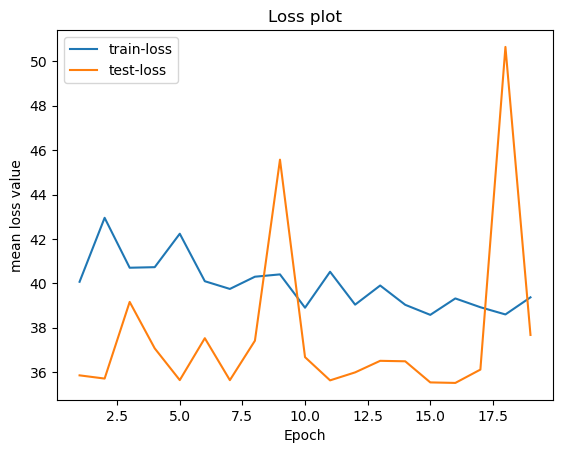

In [23]:
plt.figure()
idx = np.arange(len(loss_history_train))
offset = 1
plt.plot(idx[offset:], loss_history_train[offset:], label="train-loss")
plt.plot(idx[offset:], loss_history_test[offset:], label="test-loss")
plt.title("Loss plot")
plt.xlabel("Epoch")
plt.ylabel("mean loss value")
plt.legend()
plt.show()

In [24]:
test_loss = torch.nn.CrossEntropyLoss()

In [25]:
label = torch.tensor([0., 1.,2.,3.,4.])
pred = torch.tensor([1.1, 1., 2., 2., 4.])

In [26]:
test_loss(pred, label)

tensor(16.1880)

todo:
- build option for classification instead of regression
- either still predict number or make softmax classification

## Test/Debug

for x,y in train_loader:
    break

x.shape

x

y.shape

y

for i in range(1000):
    optimizer.zero_grad()
    prediction = model(x).flatten()
    loss = criterion(prediction, y)
    print(f"Epoch:{i+1} - loss:{loss}")
    loss.backward()
    optimizer.step()

y

model(x).flatten()